# Competitive Table Tennis with Individual DDPG agents 

## Deep Multi-agent RL in Collaboration and Competition settigns

---

This notebook implements **_Deep Deterministic Policy Gradients_** (DDPG) from [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971) in pytorch to solve the 

[Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment from [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), modified for the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

![Tennis](assets/tennis.gif)

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The first experiment implmented separate Actor-Critic networks and replay memory in each of the two agents, ensuring they were truly independent. The second experiment bound the agents with a shared replay buffer. The second experiment converged much slower and so additional experiments into binding the agents were not carried out. 


## Import the necessary packages from various libraries

In [1]:
import sys, os, numpy as np
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


from unityagents import UnityEnvironment
import torch

### Install local python scripts.
- [**agent.py**](agent.py): contains the agent class.
- [**memory.py**](memory.py): contains the replay buffer class.
- [**model.py**](model.py): contains the noise & layer functions as well as the Actor and Critic network classes.
- [**trainer.py**](trainer.py): contains the build_env and ddpg functions necessary for initializing the Unity class and the training the agents. 
- [**utils**](utils): contains [plotting functions](utils/visualization.py), [model helper scripts](utils/model.py) and [file related utitlities](utils/filesystem.py).

In [2]:
from agent import *
from model import *
from trainer import *
import utils

# Load the Unity ML-Agents environment
- These are kept in a parent directory and not uploaded to the repository.
- The provided links are for Reacher single agent and twenty agents
- Linux and OSX are provided for example

In [3]:
# Tennis
fname = "../unity_envs/Tennis_Linux_NoVis/Tennis.x86_64"
# fname = "../unity_envs/Tennis_Linux/Tennis.x86_64"
# fname = "../unity_envs/Tennis.app"

## Experiment and environment configuration
The next few cells aid in configuring the experiment ID and corresponding save folder as well as parameters for loading the environments.

In [4]:
env_id = 'Tennis'
seed = 0
logdir='logdir'
exp_id = 1

fp = f'{logdir}/{env_id}_agent_exp{exp_id}/'
env_config = {
    'file_name': '../p2_hal/'+fname,
    'no_graphics': True,
    'seed': seed
}
utils.rm_dir(fp)
utils.save_config(env_config, filepath=fp+'/env_config')

Directory created: logdir/Tennis_agent_exp3/


### Initialize the Enviroment 

The environmental configuration instructs the build_env function for the parameters of the environment, including whether to generate a graphic interface.

The function also outputs the various properties of the environment. 

In [5]:
env, brain_name, num_agents, action_size, state_size = build_env(**env_config)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# Learning Algorithm
**FIX for P3**
As mentioned previously, the algorithm used here is a variant of the **Deep Deterministic Policy Gradient** (DDPG) algorithm, from [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971), shown below. The variation herein is in clipping the critic network prior each learning update. This was done as the original intention for this project was to implement _**Proximal Policy Optimization**_ (PPO) from [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/arXiv:1707.06347), which has been left to future work.

![Deep Deterministic Policy Gradient](assets/ddpg.png)

## Agent configuration
This operates in the same way as the env_config, this time, configuring the agent properties, including networks - in this case, Actor-Critic - including optimizers and clip functions. Agent config is saved to the log directory. 

Both Actor and Critic networks utilize 3 fully-connected layers and the hyperparameters below. The networks are in [_model.py_](model.py), as are the Ornstein-Uhlenbeck noise and layer initialization functions. 

In [8]:
agent_config = {
    'state_size':state_size,
    'action_size':action_size,
    'num_agents':num_agents,
    'memory_size': int(1e6),
    'batch_size': 128,
    'gamma': 0.99,
    'tau': 1e-3,
    'learning_rate_actor': 3e-4,
    'learning_rate_critic': 1e-4,
    'weight_decay': 0.0, #0001, # L2 weight decay
    'network_actor': Actor,
    'network_layers_actor': [256,256],
    'network_critic': Critic,
    'network_layers_critic':[256,256],
    'optimizer_actor': torch.optim.Adam,
    'optimizer_critic': torch.optim.Adam,
    'clip_critic': True,
    'use_noise': True,
    'filepath': f'{logdir}/{exp_id}/checkpoint',
    'random_seed': 0
}
utils.save_config(agent_config, filepath=fp+'/agent_config')

### Create the agents
Although each agent could be created with different policies, having them the same allows for self-play and auto-scaling curricula.

In [9]:
agent = Agent(**agent_config)

## Training Configuration
Parameters for the training algorithm, in this case, DDPG.

In [10]:
training_config = {
    'agent': agent,
    'env': env,
    'brain_name': brain_name,
    'n_episodes': int(1e4), 
    'max_t':None, 
    'print_every':1, 
    'checkpoint_freq':200, 
    'checkpoint_dir': fp,
    'reward_window':100, 
    'target_reward': .5,
    'add_noise':True, 
    'close':True,
}
utils.save_config(training_config, filepath=fp+'/training_config')

### Run the DDPG algorithm and train Actor-Critic Agents 

In [9]:
scores = trainer(**training_config)

Scores: a1: 0.0000 | a2: -0.0100 | (Avg: 0.00000):   0%|          | 1/10000 [00:00<17:49,  9.35it/s]


Scores from last episode and the average over 100 will update every 1 episodes.



Scores: a1: -0.0100 | a2: 0.0000 | (Avg: 0.01160):   2%|▏         | 200/10000 [01:07<1:07:45,  2.41it/s]


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: -0.0100 | a2: 0.0000 | (Avg: 0.00280):   4%|▍         | 400/10000 [02:02<52:41,  3.04it/s]  


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: -0.0100 | a2: 0.1000 | (Avg: 0.04150):   6%|▌         | 600/10000 [03:13<1:00:07,  2.61it/s]


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: -0.0100 | a2: 0.1000 | (Avg: 0.10180):   8%|▊         | 800/10000 [05:13<1:47:38,  1.42it/s]


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: -0.0100 | a2: 0.1000 | (Avg: 0.23440):  10%|█         | 1000/10000 [10:17<2:07:46,  1.17it/s]


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: -0.0100 | a2: 0.1000 | (Avg: 0.43440):  12%|█▏        | 1200/10000 [19:32<4:06:15,  1.68s/it] 


Learner saved to logdir/Tennis_agent_exp1/agent0.

Learner saved to logdir/Tennis_agent_exp1/agent1.


Scores: a1: 1.0900 | a2: 1.2000 | (Avg: 0.50200):  12%|█▏        | 1235/10000 [22:09<8:39:59,  3.56s/it]  
Environment solved in 1136 episodes!	Average Score: 0.50:  12%|█▏        | 1235/10000 [22:09<8:39:59,  3.56s/it]


Learner saved to /agent0.

Learner saved to /agent1.
Finished training.


# Plot of Rewards
## Visualize the Agents' scores during training

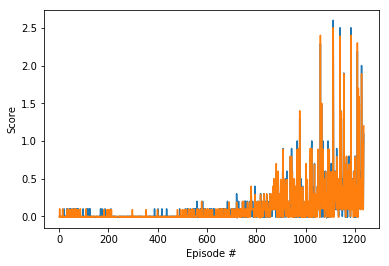

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Save the resulting scores

In [13]:
utils.save_pickle(scores, fp+'scores')

## Load scores from the results

In [ ]:
scores = utils.load_pickle(fp+'scores.pickle')

## Visualize the max score of the two agents

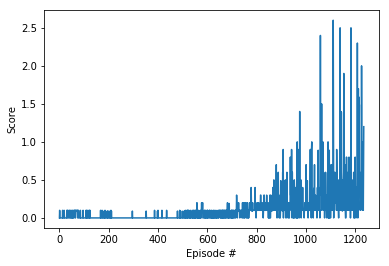

In [14]:
np.array(scores).shape
utils.plot_scores(np.max(scores, axis=1))

## Results **FIX for P3**
This method converged reaching the solution incredibly fast; after only 10 episodes the system began to learn the proper actions, managing to retrain its momentum thusly achieving an average score of 0.50200 over 100 episodes by the 1235th episode.

# Ideas for Future Work
_Multithreading Agents_ (Actors) and/or _parallelizing training_ environments will also be explored in the future, as a means for accellerating training. 

_**Proximal Policy Optimization**_ (PPO) from [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/arXiv:1707.06347) will be explored in future work, as it was not fully investigated herein.

![PPO](assets/ppo.png)